In [16]:
# Loading videos with tracking data, no model used

# Include required libraries
import os
import cv2
import pandas as pd

# Get path of dataset and load videos into a list with tracking files in a seperate list
dataset_folder = 'Dataset/'  
video_files = [f for f in os.listdir(dataset_folder) if f.endswith('.mp4')]
tracking_files = {f.split('.')[0]: f for f in os.listdir(dataset_folder) if f.endswith('.txt')}

# Loop over each video and match the txt file by video name, print if tracking is missing
for video_name in video_files:
    video_path = os.path.join(dataset_folder, video_name)
    tracking_file_name = tracking_files.get(video_name.split('.')[0])  # Match txt file by video name
    if tracking_file_name is None:
        print(f"No tracking file found for {video_name}")
        continue

    # Load tracking data, skip the first row if it contains column headers
    tracking_path = os.path.join(dataset_folder, tracking_file_name)
    tracking_df = pd.read_csv(tracking_path, sep='\s+', header=0, names=["k", "ID_i", "x", "y", "width", "height"])
    tracking_data = {int(k): g[["ID_i", "x", "y", "width", "height"]].values for k, g in tracking_df.groupby("k")}

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Get current frame ID
        frame_id = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        
        # Overlay tracking data if available for this frame
        if frame_id in tracking_data:
            for vehicle in tracking_data[frame_id]:
                ID_i, x, y, width, height = vehicle
                x, y, width, height = int(x), int(y), int(width), int(height)

                # Draw bounding box and vehicle ID
                # Green color for bounding box
                color = (0, 255, 0)
                cv2.rectangle(frame, (x, y), (x + width, y + height), color, 2)
                cv2.putText(frame, f"ID: {int(ID_i)}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Show frame with tracking information
        cv2.imshow(f"Tracking - {video_name}", frame)
        
        # Wait for a key press to either quit or skip the current video
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):  # Press 'q' to quit the entire program
            cap.release()
            cv2.destroyAllWindows()
            print("Exiting the program.")
            exit()
        elif key & 0xFF == ord('s'):  # Press 's' to skip to the next video
            print(f"Skipping video: {video_name}")
            break
    
    # Release video capture and close windows for the current video
    cap.release()
    cv2.destroyAllWindows()


Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Skipping video: honda_civic_2018_purple_02.mp4
Exiting the program.
Skipping video: mercedes_benz_glc_2018_white_02.mp4
Exiting the program.
Skipping video: Nissan Versa_2011_Grey_02.mp4
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.
Exiting the program.


In [7]:
# Load videos and use YOLOv5

# Include required libraries
import os
import cv2
import torch
import numpy as np
from collections import Counter, deque
import re
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
from tqdm import tqdm
import pandas as pd
from PIL import Image, ImageTk

# Load YOLOv5 model (pre-trained) for vehicle detection
model = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)
# Specify classes to detect: person, car, bus, motorcycle, bicycle, fire hydrant
model.classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Function to extract frames from a video
def extract_frames(video_path, output_folder, extraction_progress):
    # Get video name and create a folder for storing frames
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    video_folder = os.path.join(output_folder, video_name)
    os.makedirs(video_folder, exist_ok=True)
    
    # Open the video and get the total number of frames
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0

    # Set maximum value for extraction progress bar
    extraction_progress["maximum"] = total_frames

    # Loop through video frames and save them as images
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Save each frame as a JPEG file
        frame_filename = os.path.join(video_folder, f"frame_{frame_count:05d}.jpg")
        cv2.imwrite(frame_filename, frame)
        frame_count += 1
        # Update the extraction progress bar
        extraction_progress["value"] = frame_count
        root.update()  # Update GUI to show real-time progress
    
    cap.release()  # Release the video capture
    messagebox.showinfo("Info", f"Extracted {frame_count} frames from {video_path} into {video_folder}.")

# Function to detect vehicles in each frame
def detect_vehicles(frame, buffer, frame_number, counts_list, unique_vehicle_ids, coord_file=None, buffer_size=15, confidence_threshold=0.25):
    # Run YOLOv5 model on the frame to detect vehicles
    results = model(frame)
    detections = results.pandas().xyxy[0]
    # Filter detections based on confidence score
    detections = detections[detections['confidence'] >= confidence_threshold]
    
    # Count vehicles in the current frame
    current_frame_detections = Counter(detections['name'])
    buffer.append(current_frame_detections)
    stable_counts = Counter()
    
    # Count vehicles from the past frames in the buffer
    for past_detections in buffer:
        stable_counts.update(past_detections)
    
    # Average the counts from the past frames
    for vehicle_type in stable_counts:
        stable_counts[vehicle_type] //= len(buffer)

    # Add detection counts to the list
    counts_list.append({
        'frame': frame_number,
        'current_counts': dict(current_frame_detections),
        'stable_counts': dict(stable_counts)
    })

    # Calculate total number of unique vehicles detected
    total_vehicle_count = sum(stable_counts.values())
    if coord_file is not None:
        # Write detection coordinates to a file for tracking
        with open(coord_file, 'a') as f:
            for i, row in detections.iterrows():
                x_center = (row['xmin'] + row['xmax']) / 2
                y_center = (row['ymin'] + row['ymax']) / 2
                width = row['xmax'] - row['xmin']
                height = row['ymax'] - row['ymin']
                vehicle_id = i + 1
                f.write(f"{frame_number}\t{vehicle_id}\t{x_center:.2f}\t{y_center:.2f}\t{width:.3f}\t{height:.3f}\n")
                
                # Track specific vehicle types like car, bus, truck
                if row['name'] in ['car', 'bus', 'truck']:
                    unique_vehicle_ids.add(vehicle_id)
            
            # Draw bounding boxes and labels on the frame
            for i, row in detections.iterrows():
                x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
                vehicle_id = i + 1 
                label = f"ID:{vehicle_id} {row['name']} {row['confidence']:.2f}"
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

    # Display current vehicle count and total unique vehicles on the frame
    cv2.putText(frame, f"Current Frame Vehicles: {len(detections)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.putText(frame, f"Total Unique Vehicles: {len(unique_vehicle_ids)}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    return frame

# Function to process all frames and update the GUI with results
def process_frames(frame_folder, label_display, processing_progress, confidence_threshold):
    # Get a sorted list of all frame files
    frame_files = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.endswith('.jpg')],
                         key=lambda x: int(re.search(r'frame_(\d+).jpg', x).group(1)))
    
    buffer = deque(maxlen=15)  # Buffer to store previous detections
    counts_list = []  # List to store detection counts for each frame
    unique_vehicle_ids = set()  # Set to store unique vehicle IDs
    coord_file = "detection_coordinates.txt"
    
    # Open the file to write coordinates
    with open(coord_file, 'w') as f:
        f.write("frame\tID\tx_center\ty_center\twidth\theight\n")

    # Set maximum value for processing progress bar
    processing_progress["maximum"] = len(frame_files)

    # Loop through all frames and detect vehicles
    for i, frame_file in enumerate(frame_files):
        frame = cv2.imread(frame_file)
        frame_number = i + 1
        
        with torch.no_grad():
            # Detect vehicles and process the frame
            display_frame = detect_vehicles(frame.copy(), buffer, frame_number, counts_list, unique_vehicle_ids, coord_file=coord_file, confidence_threshold=confidence_threshold)
        
        # Convert frame for display in the GUI
        display_frame = cv2.resize(display_frame, (640, 360))
        display_frame = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(display_frame)
        img_tk = ImageTk.PhotoImage(image=img)
        label_display.config(image=img_tk)
        label_display.image = img_tk  # Keep a reference to avoid garbage collection
        
        # Update the processing progress bar
        processing_progress["value"] = i + 1
        root.update()  # Update GUI to show real-time progress

    # Save the detection counts to a CSV file
    counts_df = pd.DataFrame(counts_list)
    counts_df.to_csv("detection_counts.csv", index=False)
    messagebox.showinfo("Info", f"Total unique vehicles detected: {len(unique_vehicle_ids)}")

# Tkinter window function to start the extraction and processing
def start_extraction():
    # Ask the user to select a video file
    video_path = filedialog.askopenfilename(title="Select Input Video", filetypes=[("Video files", "*.mp4 *.avi *.mov *.mkv")])
    if video_path:
        output_folder = 'frames_output'
        
        # Reset progress bars before starting
        extraction_progress["value"] = 0
        processing_progress["value"] = 0

        # Extract frames from the selected video
        extract_frames(video_path, output_folder, extraction_progress)
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        video_frame_folder = os.path.join(output_folder, video_name)
        
        # Get the confidence threshold from the dropdown menu
        confidence_threshold = float(confidence_dropdown.get())
        # Start processing the frames
        process_frames(video_frame_folder, label_display, processing_progress, confidence_threshold)

# Create the Tkinter window
root = tk.Tk()
root.title("Vehicle Detection System")
root.geometry("700x900")

# Display title
tk.Label(root, text="Vehicle Detection System", font=("Arial", 16)).pack(pady=10)

# Confidence score dropdown to set the confidence threshold for vehicle detection
confidence_label = tk.Label(root, text="Confidence Threshold:")
confidence_label.pack()
confidence_dropdown = ttk.Combobox(root, values=["0.25", "0.5", "0.75", "0.9"])
confidence_dropdown.set("0.25")  # Default value
confidence_dropdown.pack()

# Extraction progress bar
extraction_label = tk.Label(root, text="Extraction Progress:")
extraction_label.pack()
extraction_progress = ttk.Progressbar(root, length=400)
extraction_progress.pack(pady=5)

# Processing progress bar
processing_label = tk.Label(root, text="Processing Progress:")
processing_label.pack()
processing_progress = ttk.Progressbar(root, length=400)
processing_progress.pack(pady=5)

# Frame display for showing processed frames
label_display = tk.Label(root)
label_display.pack(pady=10)

# Start extraction button
start_button = tk.Button(root, text="Start Extraction & Processing", command=start_extraction)
start_button.pack(pady=20)

root.mainloop()


Using cache found in C:\Users\maxpr/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-10-27 Python-3.9.18 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8187MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 


In [ ]:
%matplotlib inline

Showing Results:


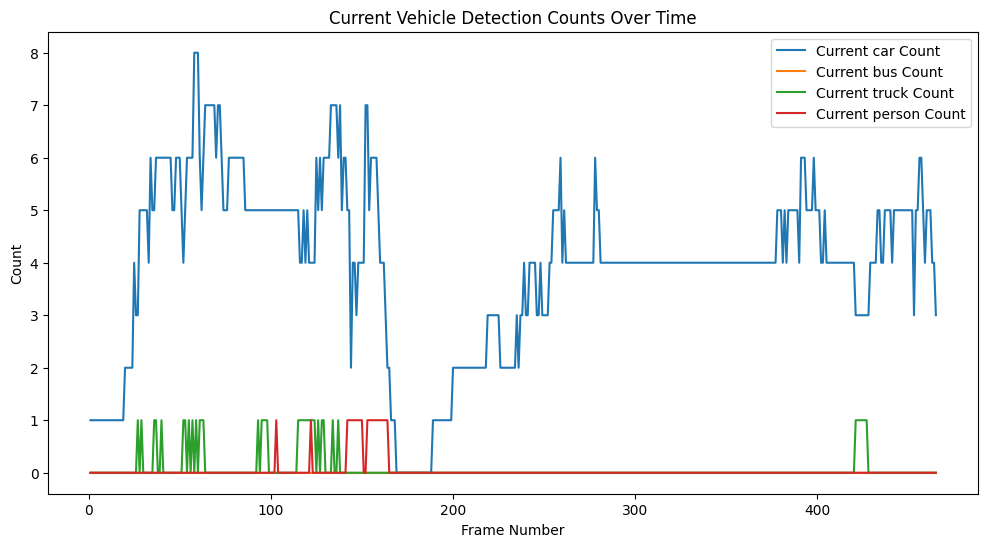

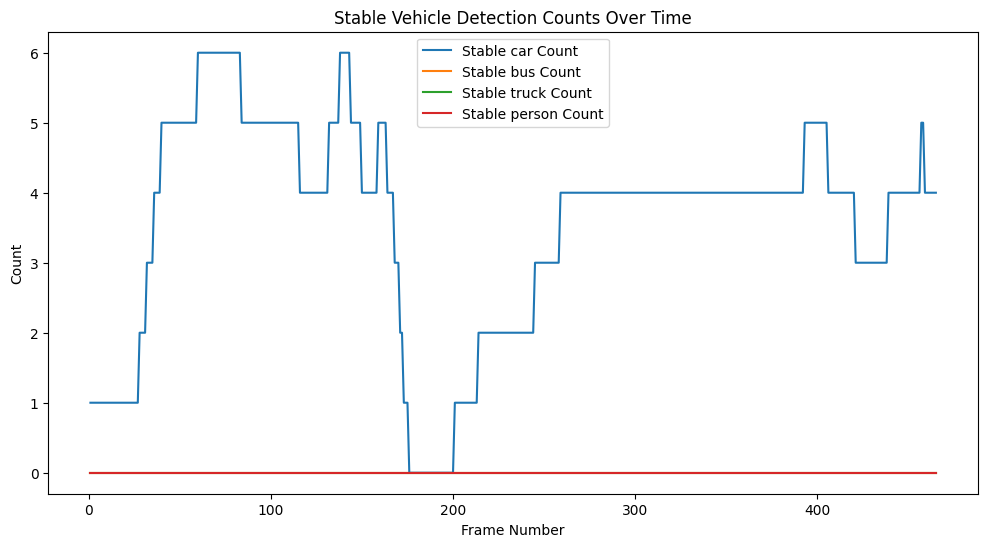

In [1]:
# Graph results

# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt

print("Showing Results:")

plt.ion()

# Plotting Results
counts_df = pd.read_csv("detection_counts.csv")
counts_df['current_counts'] = counts_df['current_counts'].apply(eval)
counts_df['stable_counts'] = counts_df['stable_counts'].apply(eval)

frames = counts_df['frame']
vehicle_types = ['car', 'bus', 'truck', "person"]

plt.figure(figsize=(12, 6))
for vehicle_type in vehicle_types:
    vehicle_counts = [count.get(vehicle_type, 0) for count in counts_df['current_counts']]
    plt.plot(frames, vehicle_counts, label=f"Current {vehicle_type} Count")
plt.title("Current Vehicle Detection Counts Over Time")
plt.xlabel("Frame Number")
plt.ylabel("Count")
plt.legend()
plt.show()

# Close the figure after showing it
plt.close()

plt.figure(figsize=(12, 6))
for vehicle_type in vehicle_types:
    stable_counts = [count.get(vehicle_type, 0) for count in counts_df['stable_counts']]
    plt.plot(frames, stable_counts, label=f"Stable {vehicle_type} Count")
plt.title("Stable Vehicle Detection Counts Over Time")
plt.xlabel("Frame Number")
plt.ylabel("Count")
plt.legend()
plt.show()

# Close the figure after showing it
plt.close()  


In [ ]:
# IoU comparision

import pandas as pd

# Function to calculate IoU between two bounding boxes
def calculate_iou(box1, box2):
    # Coordinates of the intersection rectangle
    x_left = max(box1['xmin'], box2['xmin'])
    y_top = max(box1['ymin'], box2['ymin'])
    x_right = min(box1['xmax'], box2['xmax'])
    y_bottom = min(box1['ymax'], box2['ymax'])
    
    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        
        # No overlap
        return 0.0
    
    # Area of intersection rectangle
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Area of both the prediction and ground-truth rectangles
    box1_area = (box1['xmax'] - box1['xmin']) * (box1['ymax'] - box1['ymin'])
    box2_area = (box2['xmax'] - box2['xmin']) * (box2['ymax'] - box2['ymin'])
    
    # Union area
    union_area = box1_area + box2_area - intersection_area
    
    # IoU calculation
    iou = intersection_area / union_area
    return iou

# Load detection data and filter for all cars
detection_data = pd.read_csv("detection_coordinates.txt", delimiter="\t")

# Skip the first row with the header information and reload the ground truth data
ground_truth_data = pd.read_csv("Dataset/honda_civic_2018_purple_02.txt", 
                                delim_whitespace=True, 
                                names=['frame', 'ID', 'x', 'y', 'width', 'height'],
                                skiprows=1)

# Check to make sure columns loaded correctly
print("Ground Truth Data Head:")
print(ground_truth_data.head())

print("Detection Data Head:")
print(detection_data.head())

# Initialize a list to store IoU results for each predicted car
iou_results = []

# Iterate over unique predicted car IDs
predicted_car_ids = detection_data['ID'].unique()

best_pred_id = None
best_total_iou = 0

# Compare the ground truth car against each predicted car's trajectory
for pred_id in predicted_car_ids:
    total_iou = 0
    frames_with_detections = 0
    
    # Iterate over frames in the ground truth data for car with
    for _, gt_row in ground_truth_data.iterrows():
        # Only consider ground truth data for car ID = 1
        if gt_row['ID'] != 1:
            continue
        
        # Extract ground truth bounding box and frame
        gt_frame = int(gt_row['frame'])
        gt_box = {
            'xmin': gt_row['x'] - gt_row['width'] / 2,
            'ymin': gt_row['y'] - gt_row['height'] / 2,
            'xmax': gt_row['x'] + gt_row['width'] / 2,
            'ymax': gt_row['y'] + gt_row['height'] / 2
        }
        
        # Find the corresponding detection for the predicted car in the same frame
        detection_in_frame = detection_data[(detection_data['frame'] == gt_frame) & (detection_data['ID'] == pred_id)]
        
        # If there is a detection for the predicted car in this frame, calculate IoU
        if not detection_in_frame.empty:
            det_row = detection_in_frame.iloc[0]
            # Prediction bounding box
            det_box = {
                'xmin': det_row['x_center'] - det_row['width'] / 2,
                'ymin': det_row['y_center'] - det_row['height'] / 2,
                'xmax': det_row['x_center'] + det_row['width'] / 2,
                'ymax': det_row['y_center'] + det_row['height'] / 2
            }
            
            # Calculate IoU between ground truth and prediction bounding boxes
            iou = calculate_iou(gt_box, det_box)
            total_iou += iou
            frames_with_detections += 1

    # If this predicted car has detections in some frames, calculate the total IoU
    if frames_with_detections > 0:
        # Print the total IoU for this predicted car
        print(f"Predicted Car (ID={pred_id}) total IoU: {total_iou:.3f} over {frames_with_detections} frames")
        
        # Update the best match if this car has the highest total IoU
        if total_iou > best_total_iou:
            best_total_iou = total_iou
            best_pred_id = pred_id

# Print which predicted car matches the ground truth car (ID=1) based on total IoU
print(f"\nBest matching predicted car for ground truth car (ID=1) is Predicted Car (ID={best_pred_id}) with total IoU = {best_total_iou:.3f}")
